Описание проекта:

Я работаю в приложении по доставке готовых продуктов. Коллега предоставил мне результаты двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные.             
Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

**Задача:** определить, есть ли различия в этих группах. 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### Первый тест

In [2]:
group_1_task_1 = pd.read_csv('5_task_1.csv')
group_1_task_1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [3]:
group_1_task_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.3+ KB


In [4]:
# Посчитаю кол-во заказанных блюд в каждой из групп
group_1_task_1.groupby('group', as_index=False)['events'].sum() \
              .sort_values('events', ascending=False)

,group,events
1,B,376136
0,A,295796
2,C,274703


In [5]:
# С помощью теста Левена проверю, являются ли дисперсии внутри групп одинаковыми!
group_A = group_1_task_1.query("group == 'A'")['events']
group_B = group_1_task_1.query("group == 'B'")['events']
group_C = group_1_task_1.query("group == 'C'")['events']

st.levene(group_A, group_B, group_C)
# Так как pvalue=0.1041 > 0.05 => мы не отклоняем нулевую гипотезу о равенстве дисперсий.

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

##### Рассмотрим распределение данных в наших группах

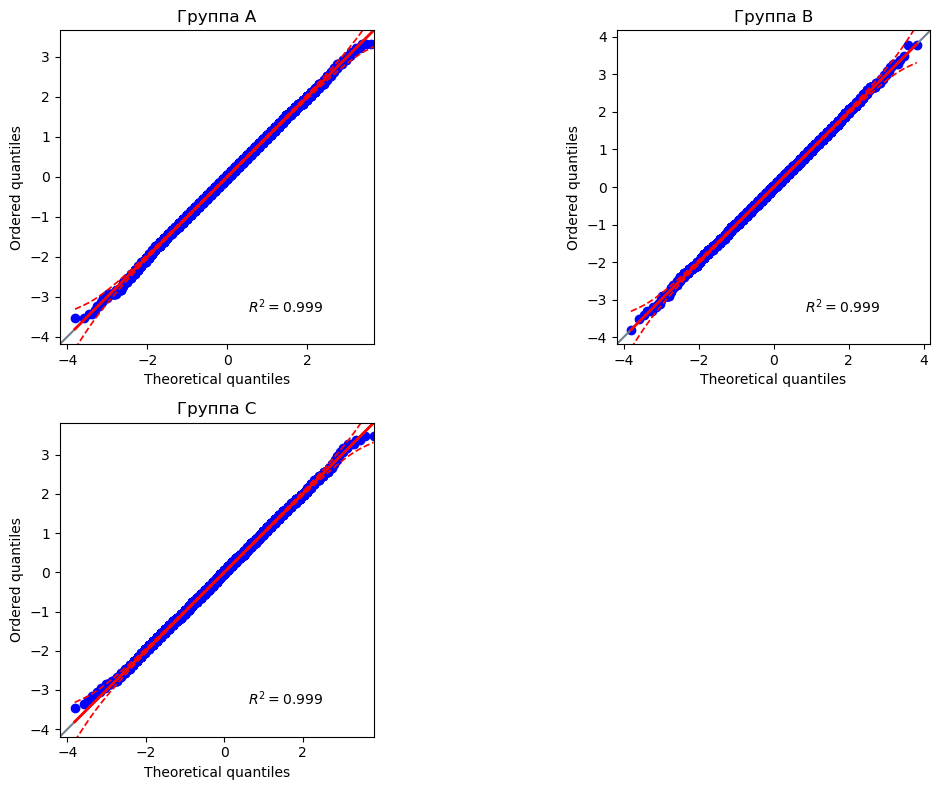

In [6]:
# Посотрим QQ-график для каждого из распределений
plt.figure(figsize=(12, 8))
plt.subplot(221)
pg.qqplot(group_A)
plt.title('Группа A')

plt.subplot(222)
pg.qqplot(group_B)
plt.title('Группа B')

plt.subplot(223)
pg.qqplot(group_C)
plt.title('Группа C')

plt.tight_layout()
plt.show()

In [7]:
# по графикам видно, что данные распределены нормально. Но также для проверки проведу тест Шапиро-Уилка

In [21]:
len(group_A) 

10000

In [25]:
# Т.к. выборка у нас более 5000, то лучше проведу тест Д'Агостино-Пирсона на нормальность:
print(f'Группа A: {st.normaltest(group_A)}')
print(f'Группа B: {st.normaltest(group_B)}')
print(f'Группа C: {st.normaltest(group_C)}')

Группа A: NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
Группа B: NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
Группа C: NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


In [29]:
print(f'''{'Данные в группе A распределены не нормально' if st.normaltest(group_A)[1] < 0.05 else 'Данные в группе A распределены нормально'}
{'Данные в группе B распределены не нормально' if st.normaltest(group_B)[1] < 0.05 else 'Данные в группе B распределены нормально'}
{'Данные в группе C распределены не нормально' if st.normaltest(group_C)[1] < 0.05 else 'Данные в группе C распределены нормально'}''')

Данные в группе A распределены нормально
Данные в группе B распределены нормально
Данные в группе C распределены нормально


##### Проведу однофакторный дисперсионный анализ

In [30]:
pg.anova(data=group_1_task_1, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [31]:
model = smf.ols(formula="events ~ group", data=group_1_task_1).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
group,2.0,5.729361e+05,286468.062300,2886.166657,0.0
Residual,29997.0,2.977369e+06,99.255551,NaN,NaN


##### Проведу тот же самый анализ, только с поправкой Тьюки

In [32]:
# Поправка Холма-Бонферрони
pg.pairwise_tests(data=group_1_task_1,
                  dv='events',
                  between='group',
                  padjust='holm'
                 )

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,7.500262e-50,holm,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,1.024138


In [33]:
# Поправка Тьюки
pg.pairwise_tukey(data=group_1_task_1,
                  dv='events',
                  between='group'
                 )

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


In [34]:
# Попрака Геймса-Хоувелла
pg.pairwise_gameshowell(data=group_1_task_1,
                        dv='events',
                        between='group'
                       )

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,6.412648e-13,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,6.349254e-12,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.000000e+00,1.024138


**Вывод:** Между всеми парами групп есть статистические значимые различия средних, т.к. везде pval < 0.05

В итоге желательно использовать картинки группы B. Смотря на колонку diff (это разность средних значений в группах) видим, что ср. группы B больше ср.группы A и C

#### Второй тест

In [35]:
group_2_task_2 = pd.read_csv('5_task_2.csv')

In [36]:
group_2_task_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   group    100000 non-null  object 
 2   segment  100000 non-null  object 
 3   events   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [37]:
group_2_task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [42]:
# Это расположение кнопки, либо верху либо внезу
group_2_task_2['segment'].unique()

array(['high', 'low'], dtype=object)

In [39]:
group_2_task_2['group'].unique()

array(['test', 'control'], dtype=object)

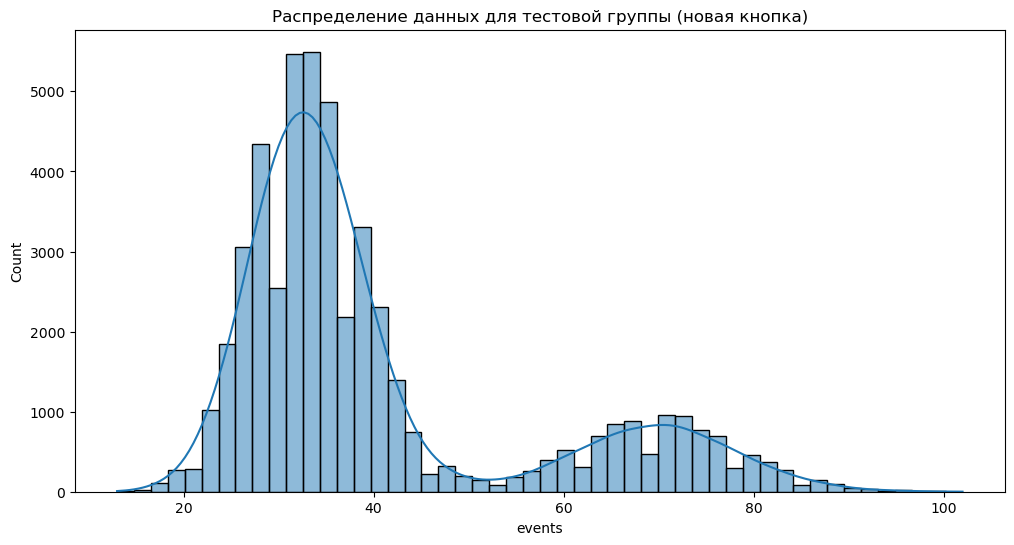

In [40]:
plt.figure(figsize=(12, 6))
sns.histplot(data=group_2_task_2.query('group == \'test\''), x='events', bins=50, kde=True, alpha=0.5)
plt.title('Распределение данных для тестовой группы (новая кнопка)')

plt.show()

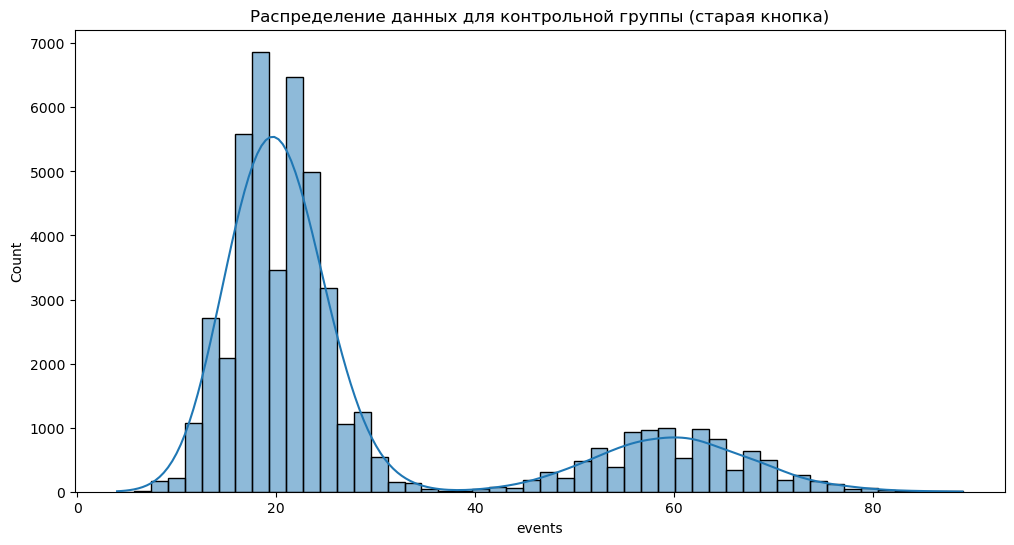

In [41]:
plt.figure(figsize=(12, 6))
sns.histplot(data=group_2_task_2.query('group == \'control\''), x='events', bins=50, kde=True, alpha=0.5)
plt.title('Распределение данных для контрольной группы (старая кнопка)')

plt.show()

In [43]:
# выведу описательную статистику по группам/сегментам
group_2_task_2.groupby(by=['segment', 'group'], as_index=False)['events'].describe()

,segment,group,count,mean,std,min,25%,50%,75%,max
0,high,control,10000.0,59.970800,7.805347,31.0,55.0,60.0,65.0,89.0
1,high,test,10000.0,69.938500,8.403974,40.0,64.0,70.0,76.0,102.0
2,low,control,40000.0,20.031575,4.473576,4.0,17.0,20.0,23.0,41.0
3,low,test,40000.0,33.025925,5.720845,13.0,29.0,33.0,37.0,59.0


##### Поскольку в каждой группе мы также учитываем расположение кнопки (вверху или внизу), для выявления статистически значимых различий между группами я проведу двухфакторный дисперсионный анализ

In [44]:
# библиотека statsmodels
model = smf.ols(formula='events ~ group + segment + group:segment', 
                data=group_2_task_2).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment,1.0,2.362480e+07,2.362480e+07,689756.377485,0.000000e+00
group:segment,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [45]:
# библиотека pingoin
pg.anova(data=group_2_task_2, 
         dv='events', 
         between=['group', 'segment']
        )

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [46]:
# Таким образом, везде p_value < 0.05 => между всеми группами есть статистические значимые различия

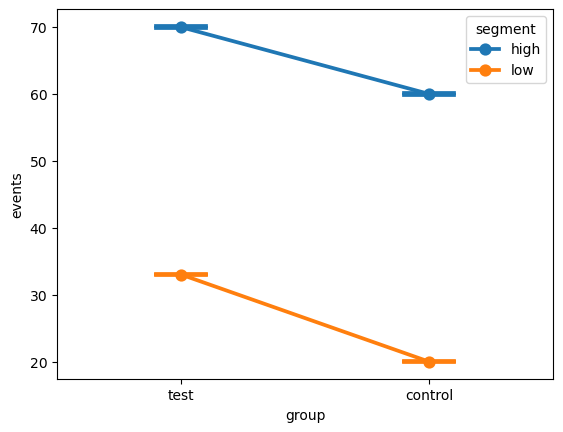

In [47]:
# Построю точечный график средних с доверительными интервалами
sns.pointplot(data=group_2_task_2,
              x='group',
              y='events',
              hue='segment',
              capsize=0.2)

plt.show()

##### Вывод

Фактор group оказался статзначимым, фактор segment тоже статзначимым и их взаимодействие тоже статзначимо. 
Судя по графику и по моим расчетам, для обоих сегментов среднее значение events увеличилось => выкатываем новую версию кнопки заказов!